In [18]:
import pandas as pd
import ast
import numpy as np
from treebased import TB_Network
import matrix as mx
import pickle as pkl
import tools as ts
import pandas as pd

In [19]:
def genesis_labeling(TB,loss_cost,fa_cost):
    def _base_case_value(dp_table,v,label,gain,char):
        if v.chars[char] == False:
            if label == 0 and gain == 0:
                return(0)
            else:
                return(1000000000) #not inf but something very big
        else:
            if label == 1:
                return(0)
            else:
                return(1000000000) #same

    def _inner_case_value(dp_table,v,current_label,current_gain,M):
        #Special case: V[v,0,1]
        # This case fixes one child as origin and leaves the rest to fate
        if current_label == 0 and current_gain == 1:
            child_sum = []
            for child in v.children:
                origin_penalty = []
                for l in [0,1]:
                    #origin_penalty.append(dp_table[child][l,1] + M[current_label,l])
                    origin_penalty.append(dp_table[child][l,1])
                brother_sum = 0
                for brother in v.children:
                    if brother != child:
                        label_cost = []
                        for l in [0,1]:
                            label_cost.append(dp_table[brother][l,0] + M[current_label,l])
                        brother_sum = brother_sum + min(label_cost)
                child_sum.append(min(origin_penalty) + brother_sum)
            return(min(child_sum))
        else:
            cost = 0
            for child in v.children:
                label_costs = []
                for l in [1,0]:
                    label_costs.append(dp_table[child][l,0] + M[current_label,l])
                cost = cost + min(label_costs)
            return cost

    #Backtracking
    def _find_best_child_origin(dp_table,v,M):
        argmin = []
        children = list(v.children)
        for child in v.children:
            origin_penalty = []
            for l in [0,1]:
                origin_penalty.append(dp_table[child][l,1] + M[0,l])
            brother_sum = 0
            for brother in v.children:
                if brother != child:
                    label_cost = []
                    for l in [0,1]:
                        label_cost.append(dp_table[brother][l,0] + M[0,l])
                    brother_sum = brother_sum + min(label_cost)
            argmin.append(min(origin_penalty) + brother_sum)
        
        index_min = np.argmin(argmin)
        return(children[index_min])


    #cost matrix
    M = np.array([[0.0,fa_cost],[loss_cost,0.0]])
    dp_table = dict()

    # Main algo
    for char in range(0,len(TB.root.chars)):
        dp_table = dict()

        #main algo
        for v in TB.postorder():

            dp_table[v] = dict()
            for label in [0,1]:
                for gain in [0,1]:
                    if v.is_leaf():
                        dp_table[v][label,gain] = _base_case_value(dp_table,v,label,gain,char)
                    else:
                        dp_table[v][label,gain] = _inner_case_value(dp_table,v,label,gain,M)

        #backtracking
        origin = None
        for v in TB.preorder():
            if v == TB.root:
                if dp_table[v][1,1] <= dp_table[v][0,1]:
                    v.chars[char] = True
                    origin = TB.root
                else:
                    v.chars[char] = False
                    #choose the origin
                    origin = _find_best_child_origin(dp_table,v,M)
           
            else:
                if v == origin:
                    if dp_table[v][1,1] <= dp_table[v][0,1]:
                        v.chars[char] = True
                    else:
                        v.chars[char] = False
                        #choose the origin
                        if not v.is_leaf():
                            origin = _find_best_child_origin(dp_table,v,M)
                else:
                    if dp_table[v][1,0] <= dp_table[v][0,0]:
                        v.chars[char] = True
                    else:
                        v.chars[char] = False

In [24]:
def network_cost_by_character(network,KOs,loss_penalty,trans_penalty):
    losses_per_character = []
    fas_per_character = []
    for char in range(0,len(network.root.chars)):
        transfer_cost = 0
        loss_cost     = 0

        for u,v in network.tree_edges():
            label_u = u.chars[char]
            label_v = v.chars[char]
            if label_u != label_v:
                if label_u == True and label_v == False:
                    loss_cost+=1
                else:
                    transfer_cost+=1
        if transfer_cost > 1:
            transfer_cost = transfer_cost - 1
        loss_cost = loss_cost*loss_penalty
        transfer_cost = transfer_cost*trans_penalty
        losses_per_character.append(loss_cost)
        fas_per_character.append(transfer_cost)

    results = pd.DataFrame()
    results['characters'] = KOs
    results['losses'] = losses_per_character
    results['transfers'] = fas_per_character
    results['network_cost'] = results['losses'] + results['transfers']
    return(results)

In [25]:
input_path = "../data/sankoff_labeling_analysis/input_data/"
output_path = "../results/cost_analysis/"

#Import Species Tree
sname = input_path + "species_tree_ultra.pkl"
f = open(sname,"rb")
S = pkl.load(f)
f.close()

#Import KO list
koname = input_path + "ARG_related_KOs.csv"
KO_df = pd.read_csv(koname)
KOs_list = list(KO_df['RF_KO'])
matrix = [KOs_list[i:i+45] for i in range(0,len(KOs_list),45)]


In [26]:
loss = 1.0
transfer = 1.0

for i in range(0,len(matrix)):
    chunk = matrix[i]
    mname = input_path + "/KO_matrices/interphylum_matrix_chunk_" + str(i) + ".pkl" 
    file = open(mname,"rb")
    m = pkl.load(file)
    file.close()

    #Initialize Sankoff network
    san_Network = TB_Network(S.root)
    san_Network.init_base_from_tralda(S,len(chunk))

    for leaf in san_Network.leaves():
        leaf.chars = m[leaf.label]

    san_Network.sankoff_labeling(loss,transfer)
    #Sankoff results
    R_sankoff  = network_cost_by_character(san_Network,chunk,loss,transfer)
    r_san_name = output_path + "sankoff_by_chunks/sankoff_equal_chunk_" + str(i) + ".pkl"
    file = open(r_san_name, 'wb')
    pkl.dump(R_sankoff,file)
    file.close()
    san_csv = output_path +  "sankoff_by_chunks/sankoff_equal_chunk_" + str(i) + ".csv"
    R_sankoff.to_csv(san_csv)

    #Initialize Genesis network
    gen_Network = TB_Network(S.root)
    gen_Network.init_base_from_tralda(S,len(chunk))

    for leaf in gen_Network.leaves():
        leaf.chars = m[leaf.label]
    genesis_labeling(gen_Network, loss,transfer)
    R_genesis = network_cost_by_character(gen_Network,chunk,loss,transfer)
    r_gen_name = output_path + "genesis_by_chunks/genesis_equal_chunk_"+ str(i) + ".pkl"
    file = open(r_gen_name, 'wb')
    pkl.dump(R_genesis,file)
    file.close()
    gen_csv = output_path + "genesis_by_chunks/genesis_equal_chunk_"+ str(i) + ".csv"
    R_genesis.to_csv(gen_csv)

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['text.usetex'] = True

sankoff_data = pd.DataFrame()
genesis_data = pd.DataFrame()

for i in range(0,len(matrix)):
    sname = output_path + "sankoff_by_chunks/sankoff_equal_chunk_" + str(i) + ".csv"
    san_indata = pd.read_csv(sname)
    sankoff_data = pd.concat([sankoff_data, san_indata])
    
    gname = output_path + "genesis_by_chunks/genesis_equal_chunk_" + str(i) + ".csv"
    gen_indata = pd.read_csv(gname)
    genesis_data = pd.concat([genesis_data, gen_indata])


fname_san = output_path + "sankoff_equal_ncost.csv"
sankoff_data.to_csv(fname_san,index=False)

fname_gen = output_path + "genesis_equal_ncost.csv"
genesis_data.to_csv(fname_gen,index=False)


print("For Sankoff ranges are the following:")
print("\t Losses: ",sankoff_data['losses'].min(),"-",sankoff_data['losses'].max())
print("\t Transfers: ",sankoff_data['transfers'].min(),"-",sankoff_data['transfers'].max())
print("\t Network: ",sankoff_data['network_cost'].min(),"-",sankoff_data['network_cost'].max())

print("For Genesis ranges are the following:")
print("\t Losses: ",genesis_data['losses'].min(),"-",genesis_data['losses'].max())
print("\t Transfers: ",genesis_data['transfers'].min(),"-",genesis_data['transfers'].max())
print("\t Network: ",genesis_data['network_cost'].min(),"-",genesis_data['network_cost'].max())


For Sankoff ranges are the following:
	 Losses:  0.0 - 9.0
	 Transfers:  0.0 - 9.0
	 Network:  0.0 - 13.0
For Genesis ranges are the following:
	 Losses:  0.0 - 11.0
	 Transfers:  0.0 - 9.0
	 Network:  1.0 - 14.0


In [28]:
def plot_cost_distribution(df,name):
    # Function to calculate Freedman-Diaconis number of bins
    def freedman_diaconis_bins(data):
        """Calculates the optimal number of bins using the Freedman-Diaconis rule."""
        data = np.asarray(data)
        
        # Calculate the interquartile range (IQR)
        Q1, Q3 = np.percentile(data, [25, 75])
        IQR = Q3 - Q1
        
        # Calculate the bin width
        # The rule is h = 2 * IQR / n^(1/3)
        n = len(data)
        if IQR == 0:
            # Handle cases where all data points are the same
            bin_width = 1
        else:
            bin_width = 2 * IQR / (n ** (1/3))
        
        # Calculate the number of bins
        if bin_width == 0:
            return 1 # Fallback to 1 bin if bin_width is zero
        else:
            num_bins = int(np.ceil((data.max() - data.min()) / bin_width))
            return num_bins if num_bins > 0 else 1
    #Main function
    sns.set_style("darkgrid")

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Colorblind-friendly colors
    colors = ['#E69F00', '#56B4E9', '#009E73']


    num_bins_losses = freedman_diaconis_bins(df['losses'])
    sns.histplot(df['losses'], bins=num_bins_losses, kde=True, color=colors[0], ax=axes[0])
    #axes[0].set_title('Losses Distribution', fontsize=14)
    axes[0].set_xlabel(r'$losses(T,\lambda)$',fontsize=25)
    axes[0].set_ylabel('Frequency',fontsize=15)
    axes[0].tick_params(axis='both', which='major', labelsize=20) 

    num_bins_transfers = freedman_diaconis_bins(df['transfers'])
    sns.histplot(df['transfers'], bins=num_bins_transfers, kde=True, color=colors[1], ax=axes[1])
    #axes[1].set_title('Transfers Distribution', fontsize=14)
    axes[1].set_xlabel(r'$gains(T,\lambda) - 1$',fontsize=25)
    axes[1].set_ylabel('Frequency',fontsize=15)
    axes[1].tick_params(axis='both', which='major', labelsize=20)

    num_bins_network_cost = freedman_diaconis_bins(df['network_cost'])
    sns.histplot(df['network_cost'], bins=num_bins_network_cost, kde=True, color=colors[2], ax=axes[2])
    axes[2].set_xlabel(r'$cost_{TL}(N,\lambda)$',fontsize=25)
    axes[2].set_ylabel('Frequency',fontsize=15)
    axes[2].tick_params(axis='both', which='major', labelsize=20)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(name)
    plt.show()

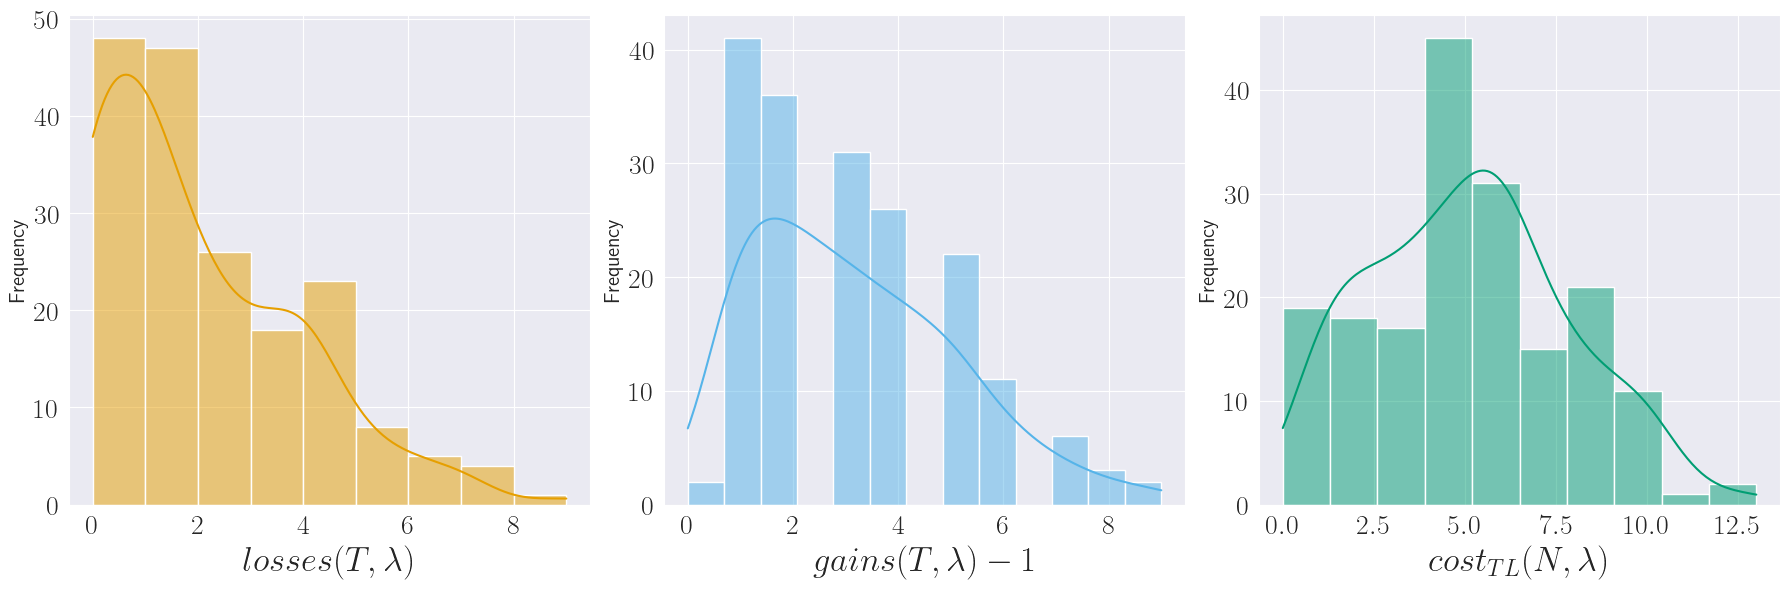

In [29]:
plot_cost_distribution(sankoff_data,"../results/cost_analysis/sankoff_cost.pdf")


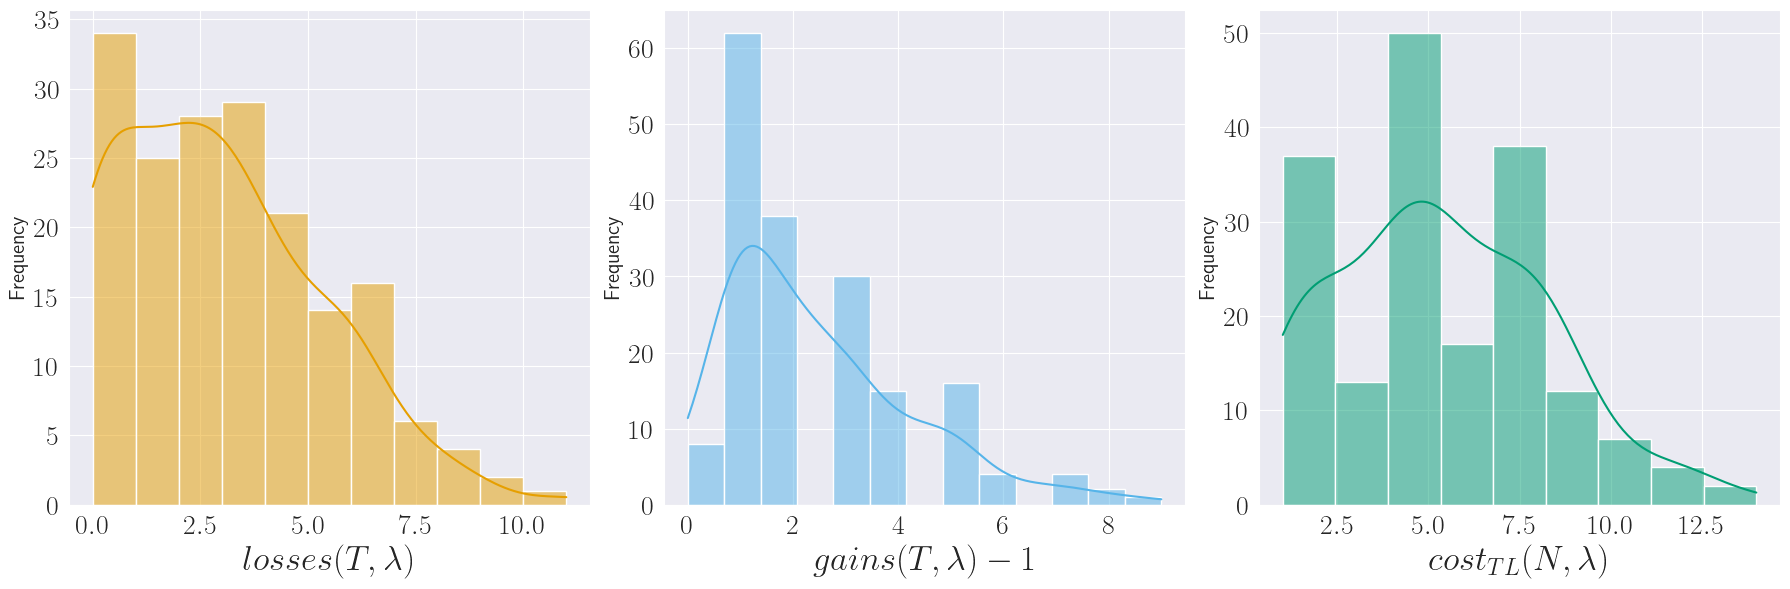

In [30]:
plot_cost_distribution(genesis_data,"../results/cost_analysis/genesis_cost.pdf")

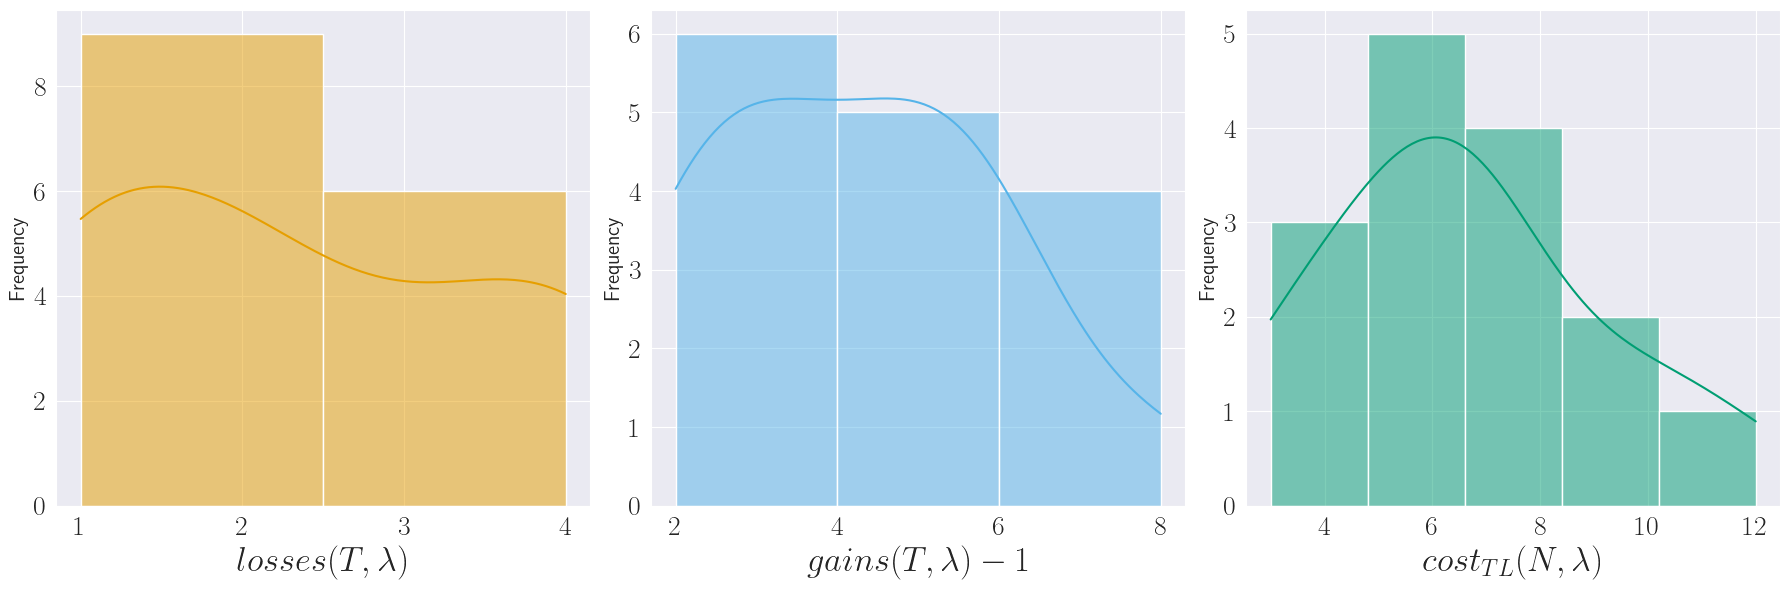

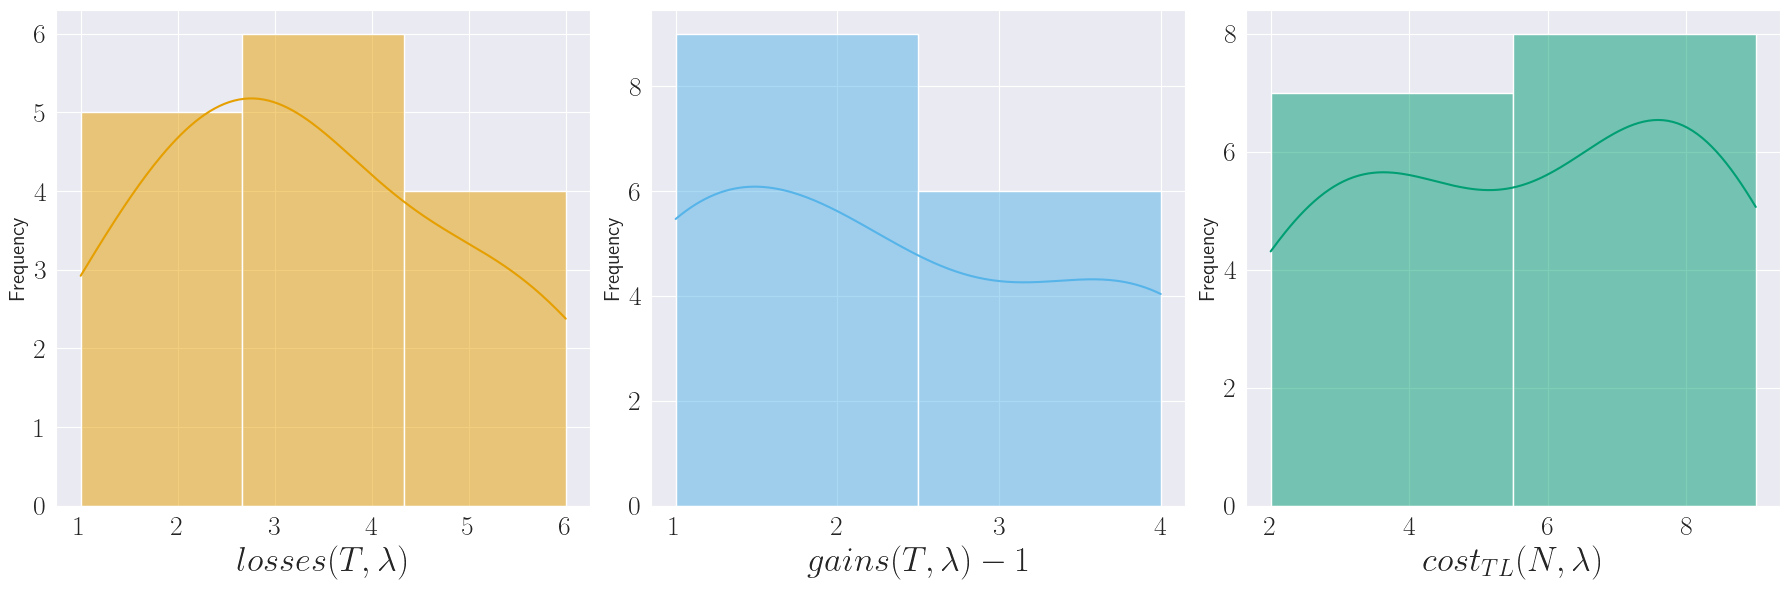

In [31]:
regain_highway_1 = ['K01669','K01011','K00135','K01589','K00252','K03782','K01029','K14162','K08973','K00019','K11473','K01679','K10764','K00140','K00208']
regain_highway_2 = ['K00632','K01903','K00681','K08296','K01902','K00242','K00252','K00121','K06916','K00140']

sankoff_hw_1 = sankoff_data[sankoff_data['characters'].isin(regain_highway_1)]
plot_cost_distribution(sankoff_hw_1,"../results/cost_analysis/sankoff_hw_1_KOs_cost.pdf")

genesis_hw_1 = genesis_data[genesis_data['characters'].isin(regain_highway_1)]
plot_cost_distribution(genesis_hw_1,"../results/cost_analysis/genesis_hw_1_KOs_cost.pdf")